<a href="https://colab.research.google.com/github/Chiranjeevi2001/introToDeepLearning/blob/main/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PyTorch Workflow
## What is covered here:
* Data (prepare and load)
* Build model
* Fitting the model to data (training)
* Making predictions
* Saving and loading a model
* Putting it all together

In [1]:
import torch
from torch import nn # nn contains ll of pytorch's building blocks for neural networks
import matplotlib.pyplot as plt

# check the pytorch version
torch.__version__

'2.1.0+cu121'

# 1. Data : Preparing and loading
Linear Regression is used to make a straight line with known parameters.

In [2]:
# Linear Regression is used to make a straight line with known parameters.

weight = 0.7
bias = 0.3

# create a range of numbers

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1) # adds extra dimension (with unsqueeze: shape = [50,1] without unsqueeze: shape = [50])

y = weight*X + bias

X.shape, y.shape

(torch.Size([50, 1]), torch.Size([50, 1]))

In [3]:
len(X), len(y)

(50, 50)

## Splitting data into training and testing sets

* training set
* validation set
* test set



In [4]:
# train test split of 80:20

train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
X_train.size(), X_test.size(), y_train.size(), y_test.size()

(torch.Size([40, 1]),
 torch.Size([10, 1]),
 torch.Size([40, 1]),
 torch.Size([10, 1]))

## Data visualization

In [5]:
def plot_prediction(train_data = X_train,
                    train_labels = y_train,
                    test_data = X_test,
                    test_labels = y_test,
                    predictions=None):
  plt.figure(figsize=(10,7))
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")
  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label = "Prediction data")

  plt.legend(prop={"size":14})

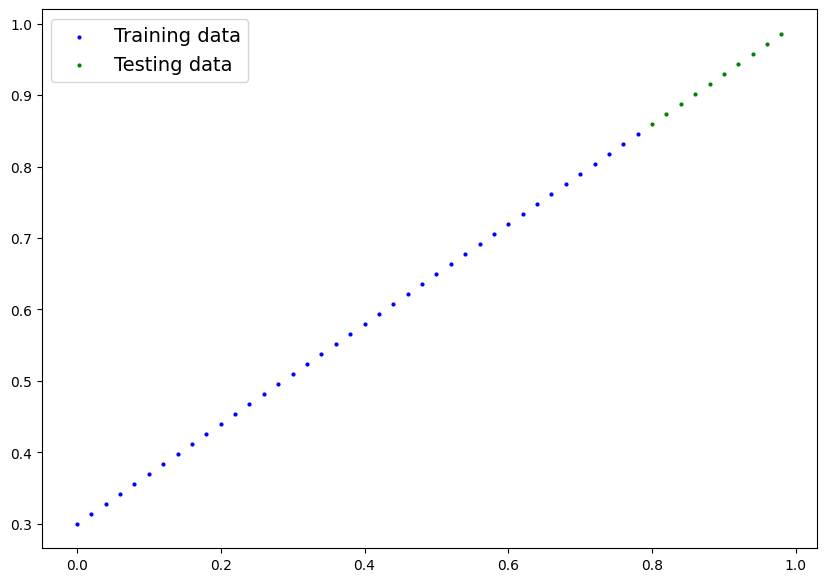

In [6]:
plot_prediction()

# 2. Build Model

In [7]:
# Create a linear regression model class

class LinearRegressionModel(nn.Module): # inherits nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                             requires_grad = True,
                                             dtype = torch.float))
    self.bias = nn.Parameter(torch.randn(1, requires_grad = True,
                                         dtype = torch.float))

  def forward(self, x:torch.Tensor) -> torch.Tensor: # x is the input tensor, the function returns yet another tensor
    return self.weights*x + self.bias # linear regression formula

## PyTorch Model Building Essentials

* `torch.nn` - contains all of the building blocks for computational graphs(neural network)
* `torch.nn.Parameter` - defines what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* `torch.nn.Module` - best class for all neural networks modules. If you inherit this, you should override forward()
* `torch.optim` - this is where the optimizers in PyTorch live. They help in Gradient Descent learning
* `def forward()` - all nn.Module subclasses require you to override forward(). It specifies what heppens at each model call


### `.parameter()` - Checking the contents of our PyTorch model


In [8]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()

# check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

In [10]:
%%time
y_preds = model_0(X_test)
y_preds

CPU times: user 244 µs, sys: 40 µs, total: 284 µs
Wall time: 292 µs


tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

In [11]:
%%time
with torch.inference_mode(): #context manager -- turns off gradient tracking and makes predictions faster
  y_preds = model_0(X_test)

y_preds

CPU times: user 1.34 ms, sys: 58 µs, total: 1.4 ms
Wall time: 1.4 ms


tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

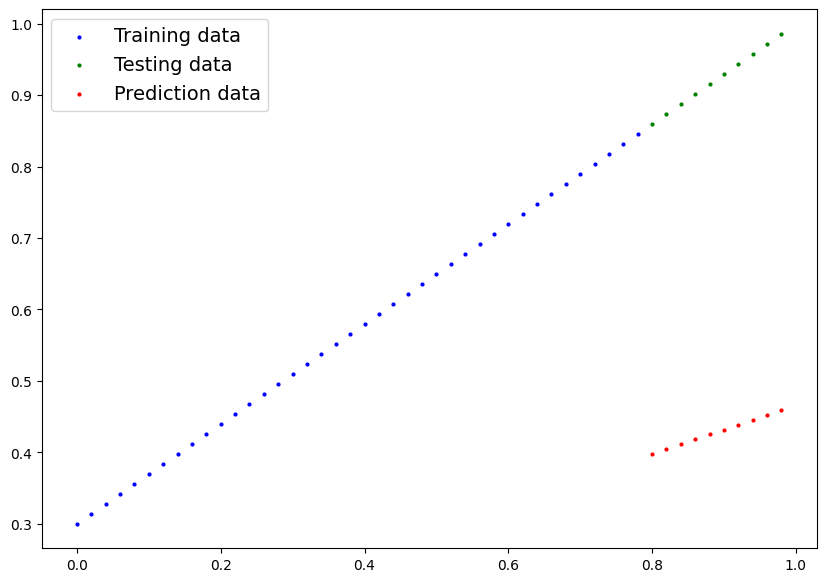

In [12]:
plot_prediction(predictions = y_preds)

# 3. Training our model

Make our model move from **unknown** (poor representation) parameters to some **known** (better representation) parameters


### Things we need to train:
* **Loss Function**:
Measures how poor your model's predictions are(aka `cost function`, `criterion`).
* **Optimizer**: takes into account the model's loss and adjusts the model's parameters to improve the loss function.

For PyTorch, we need:
* A Training loop
* A Testing loop

Inside the optimizer, you need to set two parameters:
* `params` - the model parameters you'd like to optimize.
* `lr`(learning rate) - hyperparameter that defines how big/small the optimizer changes the parameters with each step.

In [13]:
# Setup a loss function: which to use? problem specific
loss_fn = nn.L1Loss()

# Setup an Optimizer (Stochastic Gradient descent) which to use? problem specific
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr = 0.01 # learning rate, possibly the most important hyperparameter you can set
                           )

In [14]:
loss_fn

L1Loss()

### Building a training loop (and a testing loop) in PyTorch

Things we need for a training loop:
0. Loop through the data
1. Forward pass (involves data moving through our model's `forward()` function(s)) to make predictions on data (forward propagation)
2. Calculate the loss (compare forward pass predictions to ground truth)
3. Optimizer zero grad
4. Loss backwards (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**).

In [15]:
# An epoch is one loop through the data... (hyperparameter)
epochs = 200
# Track //grid search??
epoch_count = []
loss_values = []
test_loss_values = []

## Training
# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in pytorch sets all parameters that require gradients to require gradients (yes...opposite to inference mode)

  # 1. Forward Pass
  y_pred = model_0(X_train)

  # 2. Calculate the train loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform BackPropagation on the loss w.r.t the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform Gradient Descent)
  optimizer.step() # how the optimizer changes (gradients) will accumulate through the loop. So, we need to set them to zero (step 3)

  ## Testing
  model_0.eval() # turns off gradient tracking & a couple more things
  with torch.inference_mode():
    # 1. Do the forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the test loss
    test_loss = loss_fn(test_pred, y_test)

    if epoch%10==0:
      epoch_count.append(epoch)
      loss_values.append(loss)
      test_loss_values.append(test_loss)
      print("Epoch:", epoch," | Loss:",loss, " | Test Loss:", test_loss)


Epoch: 0  | Loss: tensor(0.3129, grad_fn=<MeanBackward0>)  | Test Loss: tensor(0.4811)
Epoch: 10  | Loss: tensor(0.1977, grad_fn=<MeanBackward0>)  | Test Loss: tensor(0.3464)
Epoch: 20  | Loss: tensor(0.0891, grad_fn=<MeanBackward0>)  | Test Loss: tensor(0.2173)
Epoch: 30  | Loss: tensor(0.0531, grad_fn=<MeanBackward0>)  | Test Loss: tensor(0.1446)
Epoch: 40  | Loss: tensor(0.0454, grad_fn=<MeanBackward0>)  | Test Loss: tensor(0.1136)
Epoch: 50  | Loss: tensor(0.0417, grad_fn=<MeanBackward0>)  | Test Loss: tensor(0.0992)
Epoch: 60  | Loss: tensor(0.0382, grad_fn=<MeanBackward0>)  | Test Loss: tensor(0.0889)
Epoch: 70  | Loss: tensor(0.0348, grad_fn=<MeanBackward0>)  | Test Loss: tensor(0.0806)
Epoch: 80  | Loss: tensor(0.0313, grad_fn=<MeanBackward0>)  | Test Loss: tensor(0.0723)
Epoch: 90  | Loss: tensor(0.0279, grad_fn=<MeanBackward0>)  | Test Loss: tensor(0.0647)
Epoch: 100  | Loss: tensor(0.0245, grad_fn=<MeanBackward0>)  | Test Loss: tensor(0.0565)
Epoch: 110  | Loss: tensor(0.021

In [16]:
weight, bias #true values (ground truth)

(0.7, 0.3)

In [17]:
# learned weights
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [21]:
# convert tensors to numpy to plot
import numpy as np
numpy_loss_values = np.array(torch.tensor(loss_values).numpy())
numpy_test_loss_values = np.array(torch.tensor(test_loss_values).numpy())

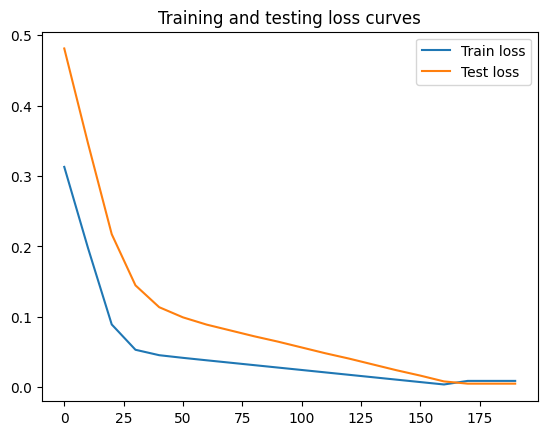

In [23]:
# Plot the loss curves

plt.plot(epoch_count, numpy_loss_values, label="Train loss")
plt.plot(epoch_count, numpy_test_loss_values, label = "Test loss")
plt.title("Training and testing loss curves")
plt.legend()
plt.show()

In [18]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

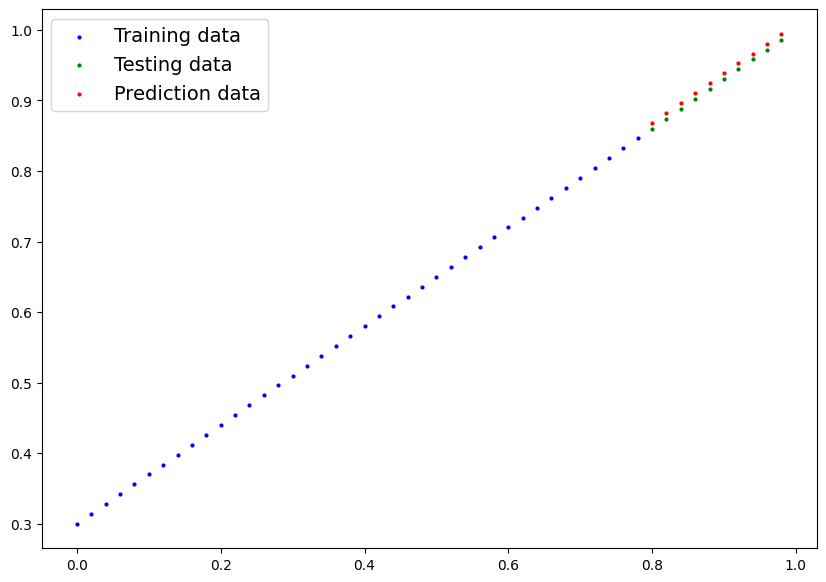

In [19]:
plot_prediction(predictions = y_preds_new)